In [1]:
%pylab inline

import jax.numpy as np
from jax import jit, grad, vmap

Populating the interactive namespace from numpy and matplotlib


## Let's define some redshift distributions

In [2]:
from jax_cosmo.redshift import smail_nz

In [21]:
nz1 = smail_nz(a=1.0, b=2., z0=0.5, zmax=2.)
nz2 = smail_nz(a=2.5, b=4., z0=1.5, zmax=3.)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Text(0.5, 0, 'redshift z')

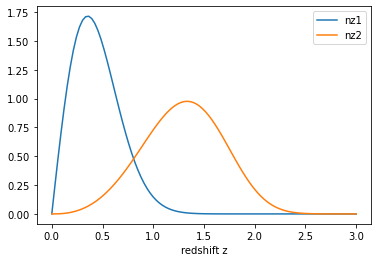

In [4]:
z=np.linspace(0,3,100)
plot(z, nz1(z), label='nz1')
plot(z, nz2(z), label='nz2')
legend()
xlabel('redshift z')

In [5]:
# Just for fun, let's check they are correctly normalized
from scipy.integrate import romberg
romberg(nz2,0,3)

DeviceArray(1., dtype=float32)

## Now, build some lensing cls

In [6]:
from jax_cosmo.core import Cosmology
from jax_cosmo.tracers import get_lensing_tracer_fn
from jax_cosmo.angular_cl import angular_cl

In [7]:
# get a cosmology
cosmo = Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, 
                  sigma8 = 0.8, n_s=0.96, Omega_k=0.,
                  w0=-1., wa=0.)

In [8]:
# Let's build a function to get some lensing cls
@jit
def lensing_cls(cosmo, ell, nz1, nz2):
    
    # We build a tracer function for each nz
    tracer_fn1 = get_lensing_tracer_fn(nz1)    
    tracer_fn2 = get_lensing_tracer_fn(nz2)

    return angular_cl(cosmo, ell, tracer_fn1, tracer_fn2)

In [9]:
ell = np.logspace(1, 3, 100)
cl = lensing_cls(cosmo, ell, nz1, nz2);

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

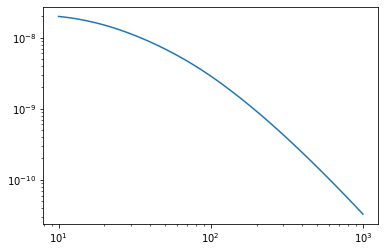

In [10]:
loglog(ell, cl)

In [11]:
# Let's compare to CCL
import pyccl as ccl
cosmo_ccl = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='linear')

tracer1 = ccl.WeakLensingTracer(cosmo_ccl, (linspace(0,6), nz1(linspace(0,6))), use_A_ia=False)
tracer2 = ccl.WeakLensingTracer(cosmo_ccl, (linspace(0,6), nz2(linspace(0,6))), use_A_ia=False)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Text(0, 0.5, 'Lensing angular $C_\\ell$')

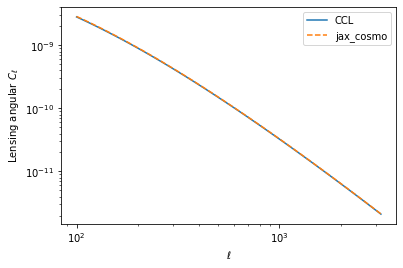

In [18]:
ell = np.logspace(2,3.5,100)

loglog(ell, ccl.angular_cl(cosmo_ccl, tracer1, tracer2, ell),label='CCL')
loglog(ell, lensing_cls(cosmo, ell, nz1, nz2), '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'Lensing angular $C_\ell$')

Ok, so we get a very good match to CCL \o/

## But wait! There is more! Let's differentiate

In [22]:
# We define a fake likelihood where the parameters are an nz
ell = np.logspace(2,3.5,100)
# Our fake data is the auto-spectrum of one redshift bin
data = lensing_cls(cosmo, ell, nz1, nz1)

# Here is our likelihood
@jit
def likelihood(nz):
    return np.sum((lensing_cls(cosmo, ell, nz, nz) - data)**2)

# And here are our gradients :-D
grad_likelihood = jit(grad(likelihood))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

In [23]:
# So for instance, we get the derivatives with respect to the nz
# But there are very small ^^'
grad_likelihood(nz2)

a : 0.000000 ; b : -0.000000 ; z0 : 0.000000 ; 

In [45]:
# Let's do some optimization
# Fitting the redshift distribution
a = 2.5
b = 4.
z0 = 1.5

nzs=[]
z = np.linspace(0, 3, 100)

for i in range(30):
    gr = grad_likelihood(smail_nz(a=a, b=b, z0=z0))
    a -= 0.2e15* gr._params['a']
    b -= 0.2e15* gr._params['b']
    z0 -= 0.2e15* gr._params['z0']
    nzs.append(smail_nz(a=a, b=b, z0=z0)(z))

print(a, b, z0)
print(nz1)
print(nz2)

2.357229 4.0668464 0.5074219
a : 1.000000 ; b : 2.000000 ; z0 : 0.500000 ; 
a : 2.500000 ; b : 4.000000 ; z0 : 1.500000 ; 


Text(0.5, 0, 'redshift z')

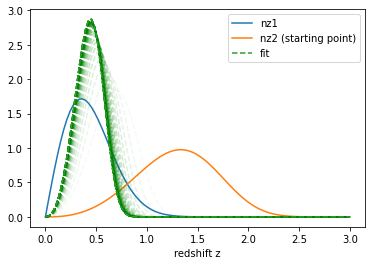

In [54]:
plot(z, nz1(z), label='nz1')
plot(z, nz2(z), label='nz2 (starting point)')
for i,n in enumerate(nzs):
    plot(z, n, '--',color='g', alpha=(i)/30.)

plot(z, smail_nz(a=a,b=b,z0=z0)(z), '--', label='fit')
legend()
xlabel('redshift z')

Text(0.5, 1.0, 'Lensing angular $C_\\ell$')

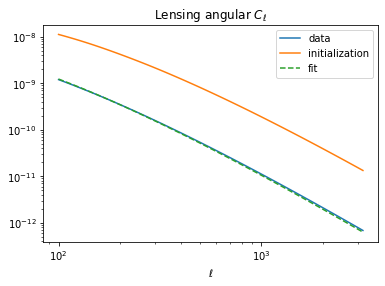

In [53]:
# And let's compare the fitted cls
nz = smail_nz(a=a, b=b, z0=z0)
loglog(ell, data,label='data')
loglog(ell, lensing_cls(cosmo, ell, nz2, nz2), label='initialization')
loglog(ell, lensing_cls(cosmo, ell, nz, nz), '--', label='fit')
legend()
xlabel(r'$\ell$')
title('Lensing angular $C_\ell$')